# Задача

Целевая переменная

* **SeriousDlqin2yrs**: Клиент имел просрочку 90 и более дней
* **RevolvingUtilizationOfUnsecuredLines**: Общий баланс средств (total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits).
* **age**: Возраст заемщика
* **NumberOfTime30-59DaysPastDueNotWorse**: Сколько раз за последние 2 года наблюдалась просрочка 30-59 дней.
* **DebtRatio**: Ежемесячные расходы (платеж по долгам, алиментам, расходы на проживания) деленные на месячный доход.
* **MonthlyIncome**: Ежемесячный доход.
* **NumberOfOpenCreditLinesAndLoans**: Количество открытых кредитов (напрмер, автокредит или ипотека) и кредитных карт.
* **NumberOfTimes90DaysLate**: Сколько раз наблюдалась просрочка (90 и более дней).
* **NumberRealEstateLoansOrLines**: Количество кредиов (в том числе под залог жилья)
* **NumberOfTime60-89DaysPastDueNotWorse**: Сколько раз за последние 2 года заемщик задержал платеж на 60-89 дней.
* **NumberOfDependents**: Количество иждивенцев на попечении (супруги, дети и др).

# Outline
1. EDA
    1. Описательные статистики
    2. Графики
2. Лог регрессия
3. OneHotEncoding 
4. Бустинг

## Подключение основных библиотек


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Подключение к БД

In [2]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-02-21 06:39:16--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-02-21 06:39:16 (453 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



In [3]:
!sudo apt update && sudo apt install --yes python3 python3-pip && \
!pip3 install psycopg2-binary

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:6 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:13 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists

In [4]:
import psycopg2

conn = psycopg2.connect("""
    host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
    port=6432
    sslmode=verify-full
    dbname=db_clients
    user=mlhs_student
    password=mlhs_student
    target_session_attrs=read-write
""")

In [5]:
query = "SELECT * from public.credit_scoring"
data_prime = pd.read_sql_query(query, conn)
conn.close()

In [6]:
df = data_prime.copy() # во время изменений иногда хочется вернуться к изначальным данным
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


Мы получили исправную таблицу

## EDA

Для начала посмотрим на описательные статистики

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [8]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [9]:
df.nunique()

SeriousDlqin2yrs                             2
RevolvingUtilizationOfUnsecuredLines    125728
age                                         86
NumberOfTime30-59DaysPastDueNotWorse        16
DebtRatio                               114194
MonthlyIncome                            13594
NumberOfOpenCreditLinesAndLoans             58
NumberOfTimes90DaysLate                     19
NumberRealEstateLoansOrLines                28
NumberOfTime60-89DaysPastDueNotWorse        13
NumberOfDependents                          13
dtype: int64

Из интересного:
* Нулевой **age** - скорее всего, это ошибка - заменить на *median*
* *Nan* значения **MonthlyIncome** и **NumberOfDependents** - заменить на *median*

In [10]:
df['age'] = df['age'].replace(0, df['age'].median)
df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
df['NumberOfDependents'].fillna(df['NumberOfDependents'].median(), inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  object 
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         150000 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    150000 non-null  float64
dtype

Посмотрим на матрицу корреляций

In [12]:
corrmat = df.corr()
corrmat

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,1.000000,-0.001802,0.125587,-0.007602,-0.017151,-0.029669,0.117175,-0.007038,0.102261,0.046869
RevolvingUtilizationOfUnsecuredLines,-0.001802,1.000000,-0.001314,0.003961,0.006513,-0.011281,-0.001061,0.006235,-0.001048,0.001193
NumberOfTime30-59DaysPastDueNotWorse,0.125587,-0.001314,1.000000,-0.006542,-0.008370,-0.055312,0.983603,-0.030565,0.987005,-0.004590
DebtRatio,-0.007602,0.003961,-0.006542,1.000000,-0.018006,0.049565,-0.008320,0.120046,-0.007533,-0.044476
MonthlyIncome,-0.017151,0.006513,-0.008370,-0.018006,1.000000,0.086949,-0.010500,0.116273,-0.009252,0.066314
NumberOfOpenCreditLinesAndLoans,-0.029669,-0.011281,-0.055312,0.049565,0.086949,1.000000,-0.079984,0.433959,-0.071077,0.074026
NumberOfTimes90DaysLate,0.117175,-0.001061,0.983603,-0.008320,-0.010500,-0.079984,1.000000,-0.045205,0.992796,-0.011962
NumberRealEstateLoansOrLines,-0.007038,0.006235,-0.030565,0.120046,0.116273,0.433959,-0.045205,1.000000,-0.039722,0.129399
NumberOfTime60-89DaysPastDueNotWorse,0.102261,-0.001048,0.987005,-0.007533,-0.009252,-0.071077,0.992796,-0.039722,1.000000,-0.012678
NumberOfDependents,0.046869,0.001193,-0.004590,-0.044476,0.066314,0.074026,-0.011962,0.129399,-0.012678,1.000000


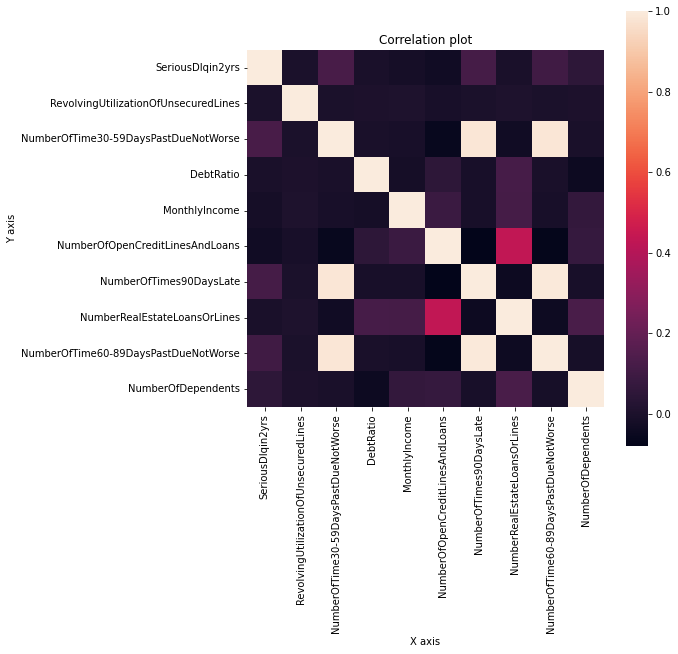

In [13]:
plt.figure(figsize = (8, 8))
sns.heatmap(corrmat, square = True)
plt.title('Correlation plot')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.show()

Можно увидеть, что три признака скоррелированы между собой. Удалим **NumberOfTimes90DaysLate** и **NumberOfTime60-89DaysPastDueNotWorse**

In [14]:
df.drop(columns=['NumberOfTimes90DaysLate',
                 'NumberOfTime60-89DaysPastDueNotWorse'],
        inplace=True)

In [15]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,6,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,1,0.0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 9 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  object 
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         150000 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberRealEstateLoansOrLines          150000 non-null  int64  
 8   NumberOfDependents                    150000 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 10.3+ MB


## Logistic Regression
Так как у нас есть несбалансированные классы (клиентов без просрочки значительно больше клиентов с просрочкой), можно попробовать с этим что-то сделать. Один из вариантов - balanced weights при использовании логистической регрессии

Logistic regression with balanced weights

In [49]:
X = df.drop('SeriousDlqin2yrs', axis=1)
y = df['SeriousDlqin2yrs']

X = X.drop(['age'], axis=1)

In [55]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

In [56]:
Xtrain.head()

,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents
92988,0.182486,0,0.217973,8000.0,8,1,2.0
43658,0.000916,0,0.238913,28750.0,7,3,2.0
110698,0.149620,0,0.101878,9000.0,7,0,0.0
77130,1.000000,0,0.000000,929.0,1,0,0.0
109216,0.057441,0,0.428893,4000.0,6,1,4.0


In [59]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xtrain = ss.fit_transform(Xtrain)
Xtest = ss.transform(Xtest)

In [60]:
from sklearn.linear_model import LogisticRegression

logit_reg_bal = LogisticRegression(class_weight = 'balanced')
logit_reg_bal.fit(Xtrain, ytrain)

logit_reg = LogisticRegression()
logit_reg.fit(Xtrain, ytrain)

train_prediction_bal = logit_reg_bal.predict_proba(Xtrain)[:, 1]
test_prediction_bal = logit_reg_bal.predict_proba(Xtest)[:, 1]

train_prediction = logit_reg.predict_proba(Xtrain)[:, 1]
test_prediction = logit_reg.predict_proba(Xtest)[:, 1]

AUC ROC on Train is 0.6285 and 0.7306 with weighting
AUC ROC on Test is 0.6385 and 0.7318 with weighting
Area Under Precision Recall Curve on Train is 0.1223 and 0.2324 with weighting
Area Under Precision Recall Curve on Test is 0.1236 and 0.2351 with weighting


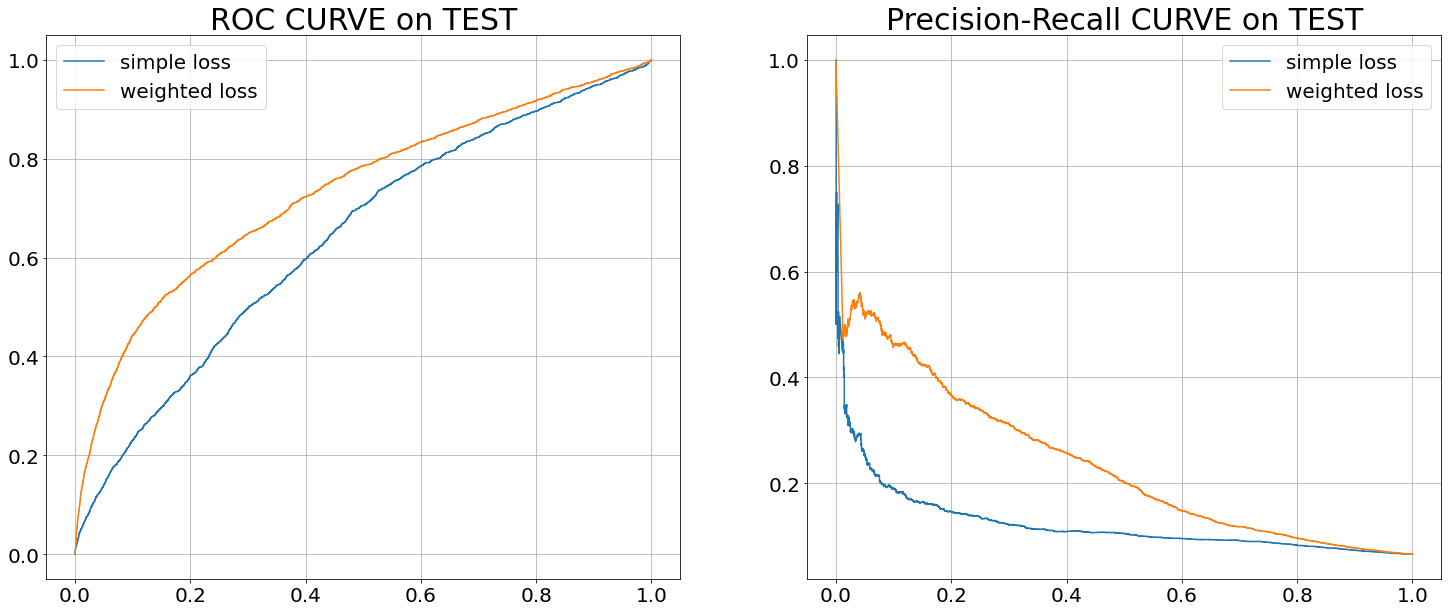

In [62]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, average_precision_score

roc_auc_train = roc_auc_score(ytrain, train_prediction)
roc_auc_train_bal = roc_auc_score(ytrain, train_prediction_bal)
roc_auc_test = roc_auc_score(ytest, test_prediction)
roc_auc_test_bal = roc_auc_score(ytest, test_prediction_bal)

print(f'AUC ROC on Train is {roc_auc_train:.4f} and {roc_auc_train_bal:.4f} with weighting')
print(f'AUC ROC on Test is {roc_auc_test:.4f} and {roc_auc_test_bal:.4f} with weighting')

prc_auc_train = average_precision_score(ytrain, train_prediction)
prc_auc_train_bal = average_precision_score(ytrain, train_prediction_bal)
prc_auc_test = average_precision_score(ytest, test_prediction)
prc_auc_test_bal = average_precision_score(ytest, test_prediction_bal)

print(f'Area Under Precision Recall Curve on Train is {prc_auc_train:.4f} and {prc_auc_train_bal:.4f} with weighting')
print(f'Area Under Precision Recall Curve on Test is {prc_auc_test:.4f} and {prc_auc_test_bal:.4f} with weighting')

prc = precision_recall_curve(ytest, test_prediction)
prc_bal = precision_recall_curve(ytest, test_prediction_bal)
ac = roc_curve(ytest, test_prediction)
ac_bal = roc_curve(ytest, test_prediction_bal)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (25, 10))

ax[0].plot(ac[0], ac[1], label = 'simple loss')
ax[0].plot(ac_bal[0], ac_bal[1], label = 'weighted loss')
ax[0].set_title('ROC CURVE on TEST', fontsize = 30)

ax[1].plot(prc[1], prc[0], label = 'simple loss')
ax[1].plot(prc_bal[1], prc_bal[0], label = 'weighted loss')
ax[1].set_title('Precision-Recall CURVE on TEST', fontsize = 30)

for i in ax:
    i.tick_params(labelsize = 20)
    i.grid()
    i.legend(fontsize = 20)

plt.show()